# Exercise 2. Raster data preparations

In this exercise prepare the raster data for the classification excercises, where prediction of forest type is done based on a satellite image.

The data used in these exercises is orinally from:
* [Forest stands](https://www.metsaan.fi/paikkatietoaineistot) from Forest center (Metsäkeskus). The exercise area is covered by 2 files: Uusimaa and Salo. These will be merged.
* [Sentinel 2A satellite image](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products) (10m x 10m) from ESA. The data is provided with each band in separate file, so the bands will be merged.

The goal of this exercise is to have 6 raster files:

Images:
1. Sentinel image rescaled to original reflections valus for training area
1. Sentinel image rescaled to original reflections valus for prediction area

Labels:
1. Spruce forests as binary raster for training area
1. Spruce forests as binary raster for prediction area
1. Multi-class (spurce, pine, birch, other) forest raster for training area
1. Multi-class (spurce, pine, birch, other) forest raster for prediction area

In this exercise GDAL commandline commands are used, **not Python**. 

In Jupyter Notebooks, commandline commands start with **!** or **%**
* **%** means the command will be ran so that the result persists for other code cells as well. You can navigate folders
* **!** runs the command in a separate subprocess. This means that switching folders with `cd` would not work

## 2.1 Download and unzip the data 

Using basic Linux commands:
* `wget` downloads files from a URL
* `unzip` 

See the generated files from the File browser in the left panel of Jupyter Labs.

In [27]:
NOTEBOOK_HOME='/home/jovyan/work/geocomputing/machineLearning/data'

In [28]:
!mkdir -p {NOTEBOOK_HOME}
%cd {NOTEBOOK_HOME}

/home/jovyan/work/geocomputing/machineLearning/data


In [3]:
! wget https://a3s.fi/gis-courses/gis_ml/raster_data.zip
! unzip -qu raster_data.zip

--2020-10-06 07:54:42--  https://a3s.fi/gis-courses/gis_ml/raster_data.zip
Resolving a3s.fi (a3s.fi)... 86.50.254.18, 86.50.254.19
Connecting to a3s.fi (a3s.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1532213351 (1.4G) [application/zip]
Saving to: ‘raster_data.zip.2’

raster_data.zip.2   100%[===================>]   1.43G   251MB/s    in 6.5s    

2020-10-06 07:54:49 (225 MB/s) - ‘raster_data.zip.2’ saved [1532213351/1532213351]



## 2.2 Satellite image preparations

The original satellite image has each band as separate file. For **joining the bands** create first the false color composite as a virtual raster (.vrt) from the different bands.

* **B08** = infrared
* **B04** = red
* **B03** = green

Virtual raster is a handy concept for merging files. The created .vrt file is a small text file, that includes only links to the original files with data. Ofteb virtual raster file is used with data divided to mapsheets, but here all files are for the same mapsheet, so use the `-separate` option to create a file with 3 bands.

TODO: remove PROJ_LIB

In [4]:
%env PROJ_LIB=/opt/conda/share/proj/

env: PROJ_LIB=/opt/conda/share/proj/


In [25]:
%cd {NOTEBOOK_HOME}/forest/S2B_MSIL2A_20180829T100019_N0208_R122_T34VFM_20180829T184909.SAFE/GRANULE/L2A_T34VFM_A007727_20180829T100017/IMG_DATA/R10m
! gdalbuildvrt {NOTEBOOK_HOME}/forest/T34VFM_20180829T100019.vrt \
    T34VFM_20180829T100019_B08_10m.jp2 \
    T34VFM_20180829T100019_B04_10m.jp2 \
    T34VFM_20180829T100019_B03_10m.jp2 \
    -separate

/home/jovyan/work/geocomputing/machineLearning/data/forest/S2B_MSIL2A_20180829T100019_N0208_R122_T34VFM_20180829T184909.SAFE/GRANULE/L2A_T34VFM_A007727_20180829T100017/IMG_DATA/R10m
0...10...20...30...40...50...60...70...80...90...100 - done.


Finally **clip and rescale** the image. In Sentinel images, the original values have been multiplied by 10 000 to get rid of decimals (0.0001 takes more disk space than 10 000). Machine learning models like to have values between 0 and 1, so let's scale the pixel values back to original: 0 to 10 000 -> 0 to 1.

Options for the gdal_translate command:
* `-projwin` defines the new bounding box (bbox) for data. Use smaller bbox for training the models and bigger bbox for predicting.
* `-ot` image value type. Originally the data had integer type, chaning it to Float32.
* `-scale` how to scale the value: 0 to 10 000 -> 0 to 1

In [26]:
# Clip the training area
! gdal_translate T34VFM_20180829T100019.vrt T34VFM_20180829T100019_clipped_scaled.tif \
    -projwin 614500 6668500 644500 6640500 \
    -ot Float32 \
    -scale 0 10000 0 1
# Clip the original image also a bit smaller for predictions
! gdal_translate T34VFM_20180829T100019.vrt T34VFM_20180829T100019_scaled.tif \
    -projwin 604500 6698500 677000 6640000 \
    -ot Float32 \
    -scale 0 10000 0 1

Input file size is 10980, 10980
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 10980, 10980
0...10...20...30...40...50...60...70...80...90...100 - done.


## 2.3 Forest stand preparations

**Merge** the two GeoPackage files to one file, **clip** to predicting bbox and **change coordinte system** to the same as satellite image.

Options for the ogr2ogr-command:
* `stand` is the table name in original GeoPackage
* `-f` output file format - GeoPackage.
* `-t_srs` new coordinate system, EPSG:32634 is the code for UTM 34N
* `-spat` prediction bbox in UTM 34N coordinates
* `-spat_srs` EPSG code of the spat coodrinates - UTM 34N
* `-append -update` - add the second dataset to the first one.

This will take a moment

In [29]:
%cd {NOTEBOOK_HOME}/forest/

! ogr2ogr forest_clipped.gpkg MV_Salo.gpkg stand \
    -f GPKG \
    -t_srs epsg:32634 \
    -spat_srs epsg:32634 \
    -spat 604500 6698500 677000 6640000 \
    
! ogr2ogr forest_clipped.gpkg MV_Uusimaa.gpkg stand \
    -f GPKG \
    -t_srs epsg:32634 \
    -spat_srs epsg:32634 \
    -spat 604500 6698500 677000 6640000 \
    -append -update 

/home/jovyan/work/geocomputing/machineLearning/data/forest



**Rasterize** forest stand polygons and clip to the predicting bbox.

Options for the gdal_translate command:
* `-a` attribute to be used as the raster value
* `-ot` raster data type
* `-tr` pixel size
* `-te` bbox

In [30]:
! gdal_rasterize forest_clipped.gpkg -l stand forest_species.tif \
    -a maintreespecies \
    -ot Byte \
    -tr 10 10 \
    -te 604500 6640000 677000 6698500

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
Use `gdalinfo -hist` for printing the histogram of the raster values. 

In [31]:
! gdalinfo forest_species.tif -hist

Driver: GTiff/GeoTIFF
Files: forest_species.tif
       forest_species.tif.aux.xml
Size is 7250, 5850
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 34N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 34N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",21,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
     

From the histogram it can be seen, that the data has ~25 different tree species presented, but most of them have too few observations to be used for machine learning. So **reclassify** the forest main tree species to 4 classes to have enough data for each class:

Pine (1), Spruce (2), Deciduous trees (3), No forest (0)

Options for gdal_calc.py:
* `--calc` - how to calculate the values of the new raster
* `--NoDataValue` - what is the NoDataValue of the created raster

In [47]:
! gdal_calc.py -A forest_species.tif --outfile=forest_species_reclassified.tif \
--calc="0*(A==0)+1*(A==1)+2*(A==2)+3*(A>=3)" \
--NoDataValue=254 \
--quiet 

In [48]:
! gdalinfo forest_species_reclassified.tif -hist -stats

Driver: GTiff/GeoTIFF
Files: forest_species_reclassified.tif
Size is 7250, 5850
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 34N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 34N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",21,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806

Some excercises use only the spruce data for binary classification. 
Create a binary raster, with selecting only class 2 from the original rasterized image.

In [53]:
! gdal_calc.py -A forest_species.tif --outfile=forest_spruce.tif \
--calc="0*(A<2)+0*(A>2)+1*(A==2)" --quiet --NoDataValue=254

In [54]:
!gdalinfo forest_spruce.tif -hist

Driver: GTiff/GeoTIFF
Files: forest_spruce.tif
Size is 7250, 5850
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 34N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 34N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",21,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PA

**Clip** to training area bbox for both 4-class and 1-class datasets. 

In [58]:
! gdal_translate forest_spruce.tif forest_spruce_clip.tif \
    -ot Byte -projwin 614500 6668500 644500 6640500
! gdal_translate forest_species_reclassified.tif forest_species_reclassified_clip.tif \
    -ot Byte -projwin 614500 6668500 644500 6640500

Input file size is 7250, 5850
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 7250, 5850
0...10...20...30...40...50...60...70...80...90...100 - done.


In [70]:
!gdalinfo forest_spruce_clip.tif -hist 

Driver: GTiff/GeoTIFF
Files: forest_spruce_clip.tif
Size is 3000, 2800
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 34N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 34N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",21,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
     

## Plotting the datasets

In [74]:
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.plot import show_hist

In [60]:
### Function to normalize band values and enhance contrast. Just like what QGIS does automatically
def normalize(array):
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    lo, hi = np.percentile(array, (min_percent, max_percent))
    return (array - lo) / (hi - lo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


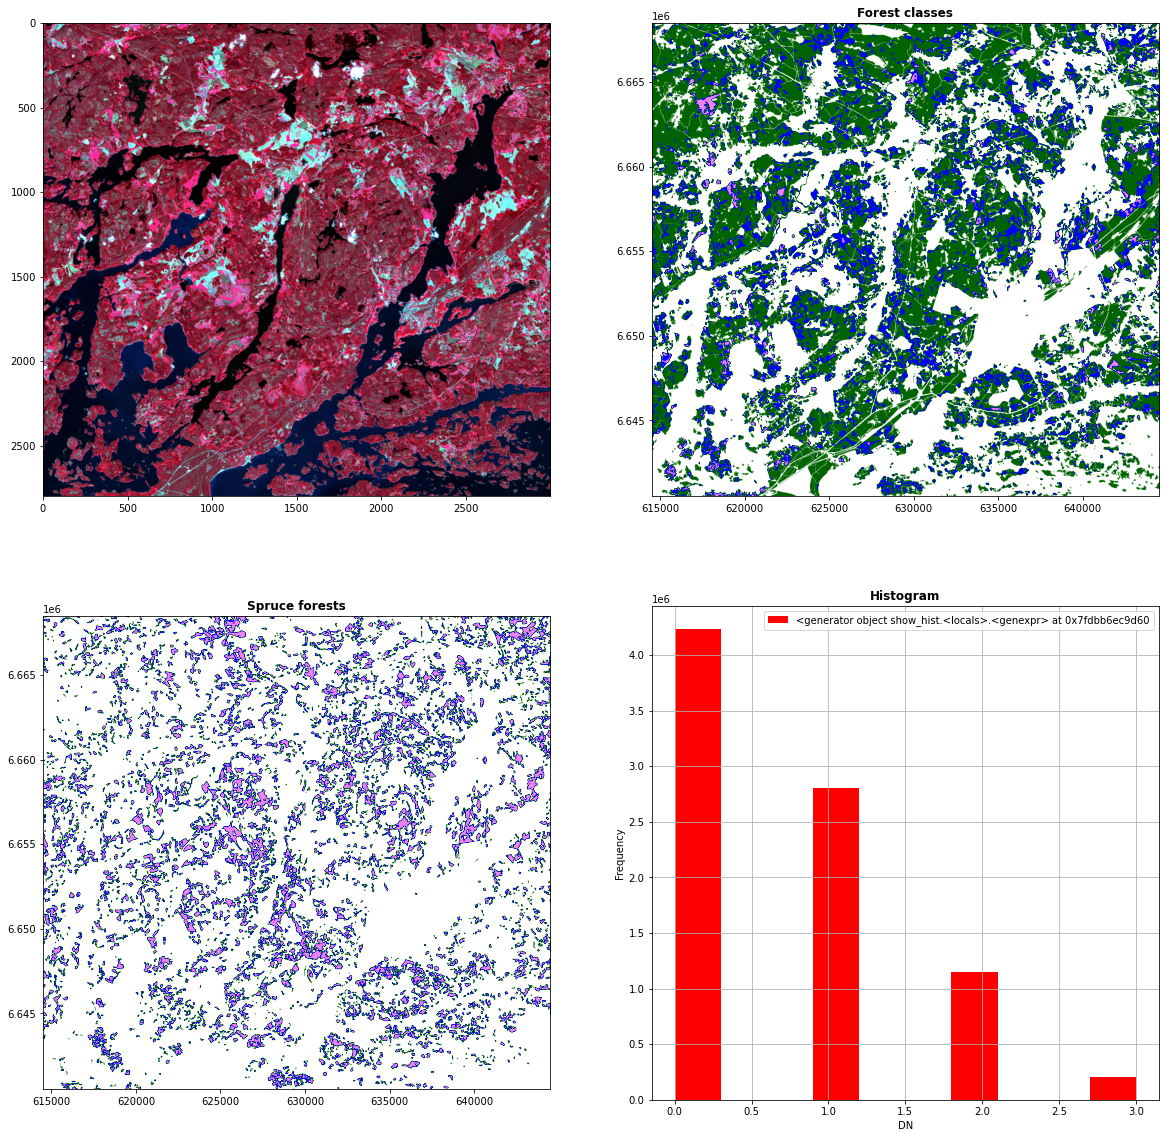

In [84]:
### This is the clipped sentinel image used in the training phases 
sentinel = rasterio.open("T34VFM_20180829T100019_clipped_scaled.tif")

### Read the bands separately and apply the normalize function to each of them to increase contrast
nir, red, green = sentinel.read(1), sentinel.read(2), sentinel.read(3)
nirn, redn, greenn = normalize(nir), normalize(red), normalize(green)
stacked = np.dstack((nirn, redn, greenn))

### Create a subplot for two images and plot the sentinel image 

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
ax[0, 0].imshow(stacked)

### The forest classification labels
forest_classes = rasterio.open("forest_species_reclassified_clip.tif")
forest_spruce = rasterio.open("forest_spruce_clip.tif")

### Plot it a bit differently as it is not an RGB image
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","darkgreen","blue","violet"])
show(forest_classes, ax=ax[0, 1], cmap=cmap, title='Forest classes')
show(forest_spruce, ax=ax[1, 0], cmap=cmap, title='Spruce forests')

show_hist(forest_classes, ax=ax[1, 1], title="Forest classes histogram")